## **Anytime Active Learning**

The following algorithm is based on the **2014 AAAI** Conference Processdings on *Anytime Active Learning *
https://cdn.aaai.org/ojs/9015/9015-13-12543-1-2-20201228.pdf

## Importing Libraries

The following libraries/modules are required for natural language preprocessing as well as trainnig the logistic regression model.

In [1]:
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from nltk.probability import FreqDist
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import pickle
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

### Utility Functions

Function for counting the number of words in each document

In [2]:
def word_count(s):
    return len(s.split())

Function to remove any html tags <> </> present in the document text

In [3]:
def striphtml(text):
    p=re.compile('<.*?>')
    return p.sub('',text)

Mounting the Drive (for accessing the data)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading the data stored in the drive (the dataset needs to be first stored in the drive and then the path of the dataset file should be mentioned here)

The dataset can be used from: https://drive.google.com/file/d/1DGX26ZClsc8N-BYikO2jCcbRAN0lyvnp/view?usp=sharing

In [5]:
df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")

Checking the number of rows and columns in the data: Two columns - one containing the document samples (reviews) and the other containing the binary labels for the sentiment of the reviews (positive or negative)

In [6]:
df.shape

(50000, 2)

In [7]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Removing the html tag from the data

In [8]:
df['review'] = df['review'].apply(striphtml)

Converting all the review text documents to lowercase

In [9]:
df['review'] = df['review'].str.lower()

Dropping all rows with documents containing less than 100 words

In [10]:
df = df.drop(df[df['review'].apply(word_count) < 100].index)

In [11]:
df.duplicated().sum()

358

Dropping duplicate values

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.shape

(43279, 2)

In [14]:
# df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

Splitting the dataset into two equal halves in order to use separate data for training the oracle simulation and pretrained classifier

In [15]:
midpoint = len(df) // 2
df1 = df.iloc[:midpoint]
df2 = df.iloc[midpoint:]

In order to save the CPU RAM, models can be pickled and stored to be reloaded at the time of use. In order to store and retrieve the models in Google Drive, the following authentication instance need to be created

In [16]:
# Authenticate and create a GoogleDrive instance
gauth = GoogleAuth()
drive = GoogleDrive(gauth)

Converting text to numeric vectors with n grams stemming of 1 to 3 using the scikit learn countvectorizer

In [17]:
cv = CountVectorizer(lowercase=True,ngram_range=(1, 3))

considering the entire first half of the dataset for oracle trainng and testing

In [18]:
sampled_data = df1.sample(n=3000, random_state=14)
# n can be changed as required

Converting the textual sentiment labels into encoded numeric values

In [19]:
encoder = LabelEncoder()
y=encoder.fit_transform(sampled_data.sentiment)

In [20]:
y.shape

(3000,)

Performing train-test split (50%)

In [21]:
X_train,X_test,y_train,y_test = train_test_split(sampled_data.iloc[:,0:1],y,test_size=0.5,random_state=1)

In [22]:
X_train['review'].shape

(1500,)

In [23]:
y_train.shape

(1500,)

Vectorizing the training set documents

In [24]:
X_train_bow = cv.fit_transform(X_train['review']).toarray()

In [25]:
X_train_bow.shape

(1500, 511118)

Training the logistic regression classifier from scikitlearn as the oracle with L2 regularization and penalty score C = 0.01 (as mentioned in the paper) and for bi class classification, setting multi_class to 'ovr'

In [26]:
oracle = LogisticRegression(penalty='l2', C=0.01, multi_class='ovr').fit(X_train_bow, y_train)

In [27]:
# # Pickle and save the model
# with open('oracle.pkl', 'wb') as model_file:
#     pickle.dump(oracle, model_file)

Function to simulate oracle behaviour (oracle assigns label to document only if it is atleast 60% certain, uncertainty threshold =0.4 as mentioned in the paper)

In [28]:
def answer(oracle,x):
    if 1 - max(oracle.predict_proba(x)[0]) > 0.4:return -1
    return oracle.predict(x)[0]

## **Anytime Active Learning**



## Static AAL

**Utility Functions**

Uncertainty function U(Xi) that outputs the uncertainty of classifier (=1-probability_of_prediction) for a given sample/set of samples Xi

In [29]:
def static_k_unc(Xik,PretrainedClassifier):
  return 1-PretrainedClassifier.predict_proba(Xik)

Static constant utility function that is always constant (=1)

In [30]:
def static_k_const(Xik,PretrainedClassifier):
  return 1

Function to generate Uk - the set of unlabelled samples with documents truncated at k words, from the entire unlabelled dataset U with complete/non-truncated documents

In [31]:
def generate_Uk(U,k):
  U = U.apply(lambda x: ' '.join(x.split()[:k]))
  return cv.transform(U).toarray()

Sampling 1000 documents from the second half of the dataset to train and test the pretrained classifier

In [32]:
sampled_data = df2.sample(n=1000, random_state=14)

Encoding the sentiment labels

In [33]:
y=encoder.fit_transform(sampled_data.sentiment)

Performing train-test split (50%), less amount of data is chosen to train to replicate the condition that very small amount of labelled data is available for supervised learning)

In [34]:
X_train,X_test,y_train,y_test = train_test_split(sampled_data.iloc[:,0:1],y,test_size=0.5,random_state=1)

Vectorizing the train and test sample documents

In [35]:
X_train_bow = cv.fit_transform(X_train['review']).toarray()

In [36]:
X_test_bow = cv.transform(X_test['review']).toarray()

Defining the select subinstance function that returnss the sample for which the ratio of utility/benefit to cost is maximum

In [37]:
def select_subinstance(U,classifier):
  return np.argmin(classifier.decision_function(U))

Considering the test data samples and the unlabelled dataset U from which samples are drawn for annotation

In [38]:
U = X_test_bow

In [39]:
k = 25

In [40]:
Uk = generate_Uk(X_test['review'],k)

In [41]:
PretrainedClassifier = LogisticRegression(penalty='l2', C=0.01, multi_class='ovr').fit(X_train_bow, y_train)

In [42]:
L = X_train_bow

In [43]:
C={10:5.7,25:8.2,50:10.9,75:15.9,100:16.7}

In [44]:
Ck = C[k]

Loading the pickled oracle model from drive

In [45]:
# with open('oracle.pkl', 'rb') as model_file:
#     oracle = pickle.load(model_file)

In [46]:
L.shape

(500, 191604)

In [47]:
y_train.shape

(500,)

In [48]:
type(U)

numpy.ndarray

Initializing the area under curve AUC and cost arrays to obtain the learning curve for AAL

In [49]:
auc=[]
cost=[]

Applying the static AAL algorithm according to 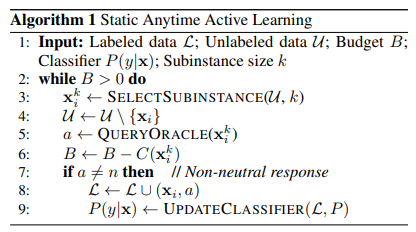

In [50]:
# Budget of 50 minutes
B = 3000
while B>0:
  print(B)
  index = select_subinstance(U,PretrainedClassifier)
  Xik = Uk[index]
  Xi = U[index]
  U=np.concatenate((U[:index], U[index + 1:]))
  a = answer(PretrainedClassifier,[Xik])
  B = B - Ck
  if a!=-1:
    L = np.concatenate((L, [Xi]))
    y_train = np.concatenate((y_train,[a]))
    PretrainedClassifier.fit(L, y_train)
    X_test_bow = cv.transform(X_test['review']).toarray()
    y_test_pred = PretrainedClassifier.predict_proba(X_test_bow)[:, 1]
    auc.append(roc_auc_score(y_test, y_test_pred))
    cost.append(3000-B)

3000
2991.8
2983.6000000000004
2975.4000000000005
2967.2000000000007
2959.000000000001
2950.800000000001
2942.6000000000013
2934.4000000000015
2926.2000000000016
2918.000000000002
2909.800000000002
2901.600000000002
2893.4000000000024
2885.2000000000025
2877.0000000000027
2868.800000000003
2860.600000000003
2852.4000000000033
2844.2000000000035
2836.0000000000036
2827.800000000004
2819.600000000004
2811.400000000004
2803.2000000000044
2795.0000000000045
2786.8000000000047
2778.600000000005
2770.400000000005
2762.2000000000053
2754.0000000000055
2745.8000000000056
2737.600000000006
2729.400000000006
2721.200000000006
2713.0000000000064
2704.8000000000065
2696.6000000000067
2688.400000000007
2680.200000000007
2672.0000000000073
2663.8000000000075
2655.6000000000076
2647.400000000008
2639.200000000008
2631.000000000008
2622.8000000000084
2614.6000000000085
2606.4000000000087
2598.200000000009
2590.000000000009
2581.8000000000093
2573.6000000000095
2565.4000000000096
2557.20000000001
2549.

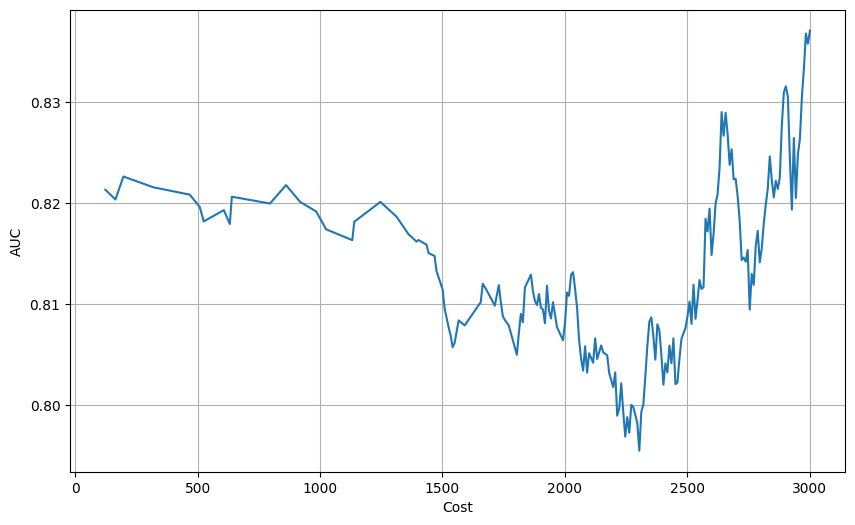

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(cost[::-1], auc)
plt.xlabel("Cost")
plt.ylabel("AUC")
plt.grid(True)
plt.show()

Repeating the entire process for conventional pool based active learning

In [52]:
sampled_data = df2.sample(n=1000, random_state=14)

In [53]:
encoder = LabelEncoder()
y=encoder.fit_transform(sampled_data.sentiment)

In [54]:
X_train,X_test,y_train,y_test = train_test_split(sampled_data['review'],y,test_size=0.5,random_state=1)

In [55]:
X_train_bow = cv.fit_transform(X_train).toarray()

In [56]:
X_test_bow = cv.transform(X_test).toarray()

In [57]:
U = X_test_bow

In [58]:
L = X_train_bow

In [59]:
PretrainedClassifier = LogisticRegression(penalty='l2', C=0.01, multi_class='ovr').fit(X_train_bow, y_train)

In [60]:
# Budget of 50 minutes
auc2=[]
cost2=[]
B = 3000
while B>0:
  print(B)
  index = select_subinstance(U,PretrainedClassifier)
  Xi = U[index]
  U=np.concatenate((U[:index], U[index + 1:]))
  a = PretrainedClassifier.predict([Xi])[0]
  B = B - 15 #considering on an average, it takes 15 seconds to annotate each sample
  L = np.concatenate((L, [Xi]))
  y_train = np.concatenate((y_train,[a]))
  PretrainedClassifier.fit(L, y_train)
  X_test_bow = cv.transform(X_test).toarray()
  y_test_pred = PretrainedClassifier.predict_proba(X_test_bow)[:, 1]
  auc2.append(roc_auc_score(y_test, y_test_pred))
  cost2.append(3000-B)

3000
2985
2970
2955
2940
2925
2910
2895
2880
2865
2850
2835
2820
2805
2790
2775
2760
2745
2730
2715
2700
2685
2670
2655
2640
2625
2610
2595
2580
2565
2550
2535
2520
2505
2490
2475
2460
2445
2430
2415
2400
2385
2370
2355
2340
2325
2310
2295
2280
2265
2250
2235
2220
2205
2190
2175
2160
2145
2130
2115
2100
2085
2070
2055
2040
2025
2010
1995
1980
1965
1950
1935
1920
1905
1890
1875
1860
1845
1830
1815
1800
1785
1770
1755
1740
1725
1710
1695
1680
1665
1650
1635
1620
1605
1590
1575
1560
1545
1530
1515
1500
1485
1470
1455
1440
1425
1410
1395
1380
1365
1350
1335
1320
1305
1290
1275
1260
1245
1230
1215
1200
1185
1170
1155
1140
1125
1110
1095
1080
1065
1050
1035
1020
1005
990
975
960
945
930
915
900
885
870
855
840
825
810
795
780
765
750
735
720
705
690
675
660
645
630
615
600
585
570
555
540
525
510
495
480
465
450
435
420
405
390
375
360
345
330
315
300
285
270
255
240
225
210
195
180
165
150
135
120
105
90
75
60
45
30
15


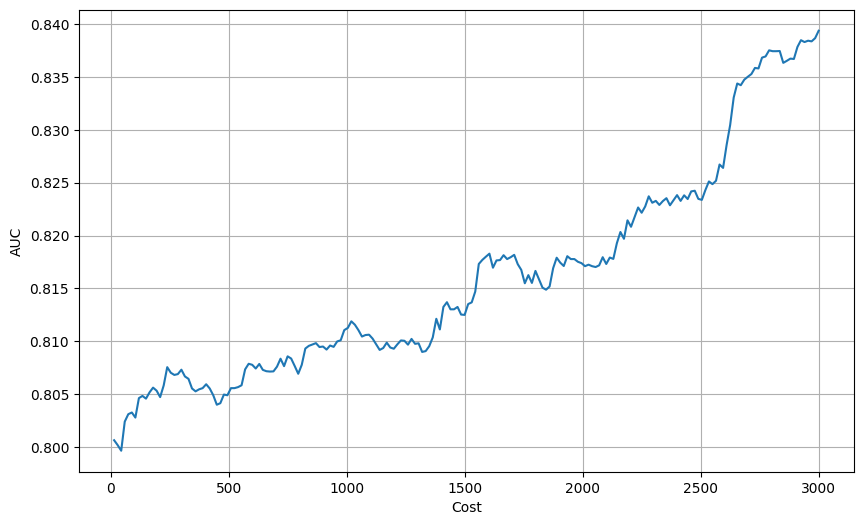

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(cost2[::-1], auc2)
plt.xlabel("Cost")
plt.ylabel("AUC")
plt.grid(True)
plt.show()

Comparing the plots for AAL k = 25 and AL (active learning)

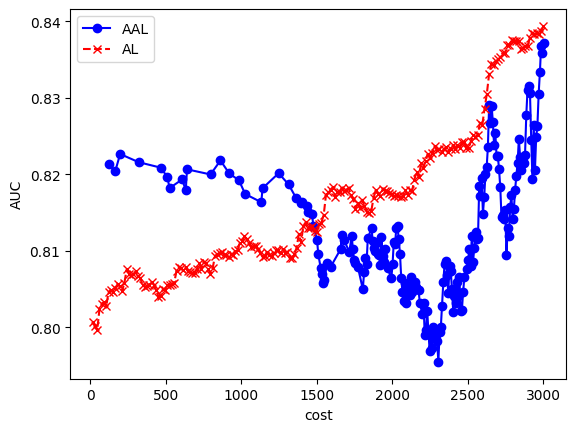

In [63]:
# Plot x1 vs y1
plt.plot(cost[::-1], auc, label='AAL', marker='o', linestyle='-', color='blue')

# Plot x2 vs y2
plt.plot(cost2[::-1], auc2, label='AL', marker='x', linestyle='--', color='red')

# Add labels, title, and legend
plt.xlabel('cost')
plt.ylabel('AUC')
plt.legend()

# Show the plot
plt.show()